# IRASA

Notes:
- Is some kind of issue when using relatively short signals (below 10 seconds)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from neurodsp.sim import *
from neurodsp.spectral import compute_spectrum

from fooof.plts import plot_spectrum, plot_spectra

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_sims

## Settings

In [5]:
# General simulation settings
n_seconds = 10
fs = 1000

# Specific settings
default_exp = -1.5
default_freq = 10

# Collect together simulation parameters
sim_params_pow = {'n_seconds' : n_seconds, 'fs' : fs}

sim_params_comb = {'n_seconds' : n_seconds, 'fs' : fs, 
                   'components' : {'sim_powerlaw' : {'exponent' : default_exp},
                                   'sim_oscillation' : {'freq' : default_freq}}}

# Set the exponent range to simulate across
exps = np.arange(-3, 0.25, 0.25)
freqs = np.arange(1, 50, 1)
pows = np.arange(0, 3, 0.25)

# Set the number of instances to run
n_instances = 50

# IRASA settings
irasa_params = {'fs' : fs, 'band' : (1, 100)}

### Example: Powerlaw Signal

In [6]:
# Simulate a powerlaw signal
sig = sim_powerlaw(n_seconds, fs, default_exp)

In [7]:
# Calculate IRASA measure of exponent
psd_freqs, psd_ap, psd_osc, fit_params = irasa(sig, **irasa_params)

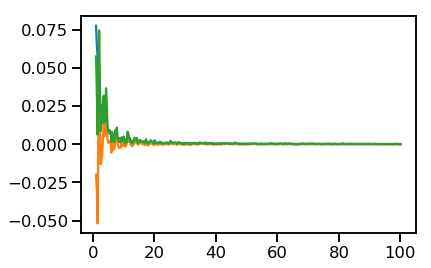

In [8]:
# Plot the different components of the power spectrum
plt.plot(psd_freqs, psd_ap[0, :])
plt.plot(psd_freqs, psd_osc[0, :])
plt.plot(psd_freqs, np.squeeze(psd_ap+psd_osc))

In [9]:
# Grab the calculate exponent value
fit_exp = fit_params['Slope'].values[0]

In [10]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(default_exp))

Measured Exponent:	 -1.4865
Expected Exponent:	 -1.5000


### Example: Knee Signal

In [11]:
# Expected exp
exp_kn = -2

In [12]:
# Simulate a signal with a knee
sig_kn = sim_synaptic_current(n_seconds, fs)

In [13]:
# Calculate IRASA measure of exponent
psd_freqs, psd_ap, psd_osc, fit_params = irasa(sig_kn, **irasa_params)

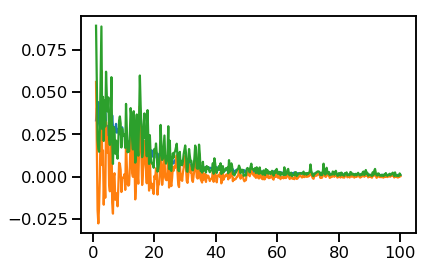

In [14]:
# Plot the different components of the power spectrum
plt.plot(psd_freqs, psd_ap[0, :])
plt.plot(psd_freqs, psd_osc[0, :])
plt.plot(psd_freqs, np.squeeze(psd_ap+psd_osc))

In [15]:
# Grab the calculate exponent value
fit_exp = fit_params['Slope'].values[0]

In [16]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(exp_kn))

Measured Exponent:	 -1.1964
Expected Exponent:	 -2.0000


### Helper Functions

In [17]:
def irasa_wrapper(sig, **kwargs):
    return irasa(sig, **kwargs)[3]['Slope'][0]

## IRASA Simulation Tests

### Powerlaw Signals - Across Exponents

In [18]:
# Run a set of simulations, calculating IRASA estimation across exponents
irasa_sims_exp = run_sims(sim_powerlaw, sim_params_pow, irasa_wrapper, irasa_params,
                          update='update_exp', values=exps, n_instances=n_instances)

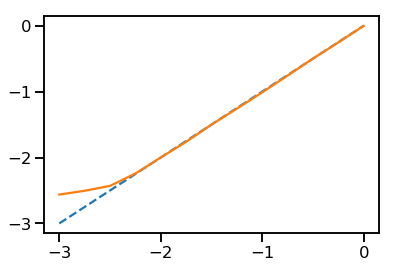

In [19]:
# Plot IRASA estimation across exponents
plt.plot(exps, exps, '--')
plt.plot(exps, irasa_sims_exp)

### Powerlaw Signals with Oscillations - Across Exponents

In [20]:
# Run a set of simulations, calculating IRASA estimation across exponents
irasa_sims_comb_exp = run_sims(sim_combined, sim_params_comb, irasa_wrapper, irasa_params,
                          update='update_comb_exp', values=exps, n_instances=n_instances)

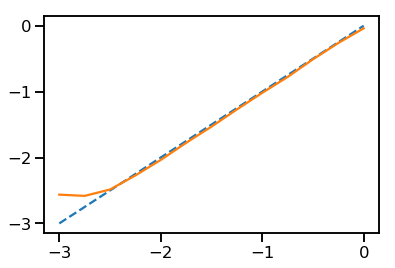

In [21]:
# Plot IRASA estimation across exponents, with oscillation
plt.plot(exps, exps, '--')
plt.plot(exps, irasa_sims_comb_exp)

### Powerlaw Signals with Oscillations - Across Oscillation Frequency

In [22]:
# Run a set of simulations, calculating IRASA across oscillation frequencies
irasa_sims_freq = run_sims(sim_combined, sim_params_comb, irasa_wrapper, irasa_params,
                           update='update_freq', values=freqs, n_instances=n_instances)

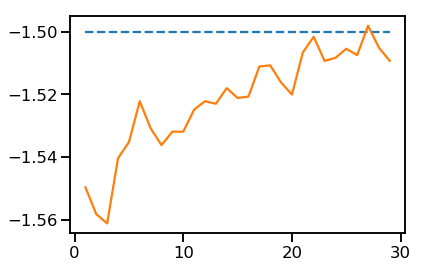

In [23]:
# Plot IRASA estimation across oscillation frequency values
plt.plot(freqs, [default_exp]*len(freqs), '--')
plt.plot(freqs, irasa_sims_freq)

### Powerlaw Signals with Oscillations - Across Oscillation Power

In [24]:
# Run a set of simulations, calculating IRASA across oscillation power
irasa_sims_pow = run_sims(sim_combined, sim_params_comb, irasa_wrapper, irasa_params,
                          update='update_pow', values=pows, n_instances=n_instances)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


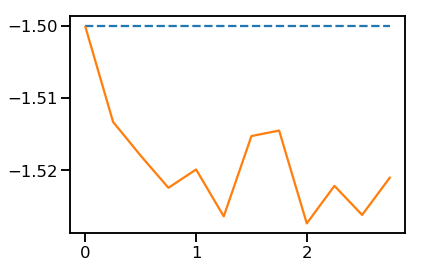

In [25]:
# Plot IRASA estimation across oscillation frequency values
plt.plot(pows, [default_exp]*len(pows), '--')
plt.plot(pows, irasa_sims_pow)

# IRASA CODE

In [4]:
import fractions
    
import numpy as np
import pandas as pd

from scipy import signal

# From YASA
# https://github.com/raphaelvallat/yasa/blob/ac57657b976e3f544ddaccc43e56f38164bb3e09/yasa/spectral.py

def irasa(data, fs=None, ch_names=None, band=(1, 30),
          hset=np.arange(1.1, 1.95, 0.05), return_fit=True, win_sec=4,
          kwargs_welch=dict(average='median', window='hamming')):
    """
    Separate the aperiodic (= fractal, or 1/f) and oscillatory component of the
    power spectra of EEG data using the IRASA method.
    .. versionadded:: 0.1.7
    
    Parameters
    ----------
    data : :py:class:`numpy.ndarray`
        1D or 2D EEG data.
    fs : float
        The sampling frequency of data AND the hypnogram.
    ch_names : list
        List of channel names, e.g. ['Cz', 'F3', 'F4', ...]. 
        If None, channels will be labelled ['CHAN001', 'CHAN002', ...].
    band : tuple or None
        Broad band frequency range. Default is 1 to 30 Hz.
    hset : :py:class:`numpy.ndarray`
        Resampling factors used in IRASA calculation. 
        Default is to use a range of values from 1.1 to 1.9 with an increment of 0.05.
    return_fit : boolean
        If True (default), fit an exponential function to the aperiodic PSD
        and return the fit parameters (intercept, slope) and :math:`R^2` of
        the fit.
        The aperiodic signal, :math:`L`, is modeled using an exponential
        function in semilog-power space (linear frequencies and log PSD) as:
        .. math:: L = a + \\text{log}(F^b)
        where :math:`a` is the intercept, :math:`b` is the slope, and
        :math:`F` the vector of input frequencies.
    win_sec : int or float
        The length of the sliding window, in seconds, used for the Welch PSD
        calculation. Ideally, this should be at least two times the inverse of
        the lower frequency of interest (e.g. for a lower frequency of interest
        of 0.5 Hz, the window length should be at least 2 * 1 / 0.5 =
        4 seconds).
    kwargs_welch : dict
        Optional keywords arguments that are passed to the
        :py:func:`scipy.signal.welch` function.
        
    Returns
    -------
    freqs : :py:class:`numpy.ndarray`
        Frequency vector.
    psd_aperiodic : :py:class:`numpy.ndarray`
        The fractal (= aperiodic) component of the PSD.
    psd_oscillatory : :py:class:`numpy.ndarray`
        The oscillatory (= periodic) component of the PSD.
    fit_params : :py:class:`pandas.DataFrame` (optional)
        Dataframe of fit parameters. Only if ``return_fit=True``.
        
    Notes
    -----
    The Irregular-Resampling Auto-Spectral Analysis (IRASA) method is
    described in Wen & Liu (2016). In a nutshell, the goal is to separate the
    fractal and oscillatory components in the power spectrum of EEG signals.
    The steps are:
    1. Compute the original power spectral density (PSD) using Welch's method.
    2. Resample the EEG data by multiple non-integer factors and their
       reciprocals (:math:`h` and :math:`1/h`).
    3. For every pair of resampled signals, calculate the PSD and take the
       geometric mean of both. In the resulting PSD, the power associated with
       the oscillatory component is redistributed away from its original
       (fundamental and harmonic) frequencies by a frequency offset that varies
       with the resampling factor, whereas the power solely attributed to the
       fractal component remains the same power-law statistical distribution
       independent of the resampling factor.
    4. It follows that taking the median of the PSD of the variously
       resampled signals can extract the power spectrum of the fractal
       component, and the difference between the original power spectrum and
       the extracted fractal spectrum offers an approximate estimate of the
       power spectrum of the oscillatory component.
    Note that an estimate of the original PSD can be calculated by simply
    adding ``psd = psd_aperiodic + psd_oscillatory``.
    
    References
    ----------
    .. [1] Wen, H., & Liu, Z. (2016). Separating Fractal and Oscillatory
           Components in the Power Spectrum of Neurophysiological Signal.
           Brain Topography, 29(1), 13–26.
           https://doi.org/10.1007/s10548-015-0448-0
    .. [2] https://github.com/fieldtrip/fieldtrip/blob/master/specest/
    .. [3] https://github.com/fooof-tools/fooof
    .. [4] https://www.biorxiv.org/content/10.1101/299859v1
    """
    

        
    # Safety checks
    assert isinstance(data, np.ndarray), 'Data must be a numpy array.'
    data = np.atleast_2d(data)
    assert data.ndim == 2, 'Data must be of shape (nchan, n_samples).'
    nchan, npts = data.shape
    assert nchan < npts, 'Data must be of shape (nchan, n_samples).'
    assert fs is not None, 'fs must be specified if passing a numpy array.'
    assert isinstance(fs, (int, float))

    if ch_names is None:
        ch_names = ['CHAN' + str(i + 1).zfill(3) for i in range(nchan)]
    else:
        ch_names = np.atleast_1d(np.asarray(ch_names, dtype=str))
        assert ch_names.ndim == 1, 'ch_names must be 1D.'
        assert len(ch_names) == nchan, 'ch_names must match data.shape[0].'

    # Check the other arguments
    hset = np.asarray(hset)
    assert hset.ndim == 1, 'hset must be 1D.'
    assert hset.size > 1, '2 or more resampling fators are required.'
    hset = np.round(hset, 4)  # avoid float precision error with np.arange.
    band = sorted(band)
    assert band[0] > 0, 'first element of band must be > 0.'
    assert band[1] < (fs / 2), 'second element of band must be < (fs / 2).'
    win = int(win_sec * fs)  # nperseg

    # Calculate the original PSD over the whole data
    freqs, psd = signal.welch(data, fs, nperseg=win, **kwargs_welch)

    # Start the IRASA procedure
    psds = np.zeros((len(hset), *psd.shape))

    for i, h in enumerate(hset):
        
        # Get the upsampling/downsampling (h, 1/h) factors as integer
        rat = fractions.Fraction(str(h))
        up, down = rat.numerator, rat.denominator
        
        # Much faster than FFT-based resampling
        data_up = signal.resample_poly(data, up, down, axis=-1)
        data_down = signal.resample_poly(data, down, up, axis=-1)
        
        # Calculate the PSD using same params as original
        freqs_up, psd_up = signal.welch(data_up, h * fs, nperseg=win, **kwargs_welch)
        freqs_dw, psd_dw = signal.welch(data_down, fs / h, nperseg=win, **kwargs_welch)
        # Geometric mean of h and 1/h
        psds[i, :] = np.sqrt(psd_up * psd_dw)

    # Now we take the median PSD of all the resampling factors, which gives
    # a good estimate of the aperiodic component of the PSD.
    psd_aperiodic = np.median(psds, axis=0)

    # We can now calculate the oscillations (= periodic) component.
    psd_osc = psd - psd_aperiodic

    # Let's crop to the frequencies defined in band
    mask_freqs = np.ma.masked_outside(freqs, *band).mask
    freqs = freqs[~mask_freqs]
    psd_aperiodic = np.compress(~mask_freqs, psd_aperiodic, axis=-1)
    psd_osc = np.compress(~mask_freqs, psd_osc, axis=-1)

    if return_fit:
        
        # Aperiodic fit in semilog space for each channel
        from scipy.optimize import curve_fit
        intercepts, slopes, r_squared = [], [], []

        def func(t, a, b):
            # See https://github.com/fooof-tools/fooof
            return a + np.log(t**b)

        for y in np.atleast_2d(psd_aperiodic):
            
            y_log = np.log(y)
            # Note that here we define bounds for the slope but not for the intercept.
            popt, pcov = curve_fit(func, freqs, y_log, p0=(2, -1),
                                   bounds=((-np.inf, -10), (np.inf, 2)))
            intercepts.append(popt[0])
            slopes.append(popt[1])
            
            # Calculate R^2: https://stackoverflow.com/q/19189362/10581531
            residuals = y_log - func(freqs, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y_log - np.mean(y_log))**2)
            r_squared.append(1 - (ss_res / ss_tot))

        # Create fit parameters dataframe
        fit_params = {'Chan': ch_names, 'Intercept': intercepts,
                      'Slope': slopes, 'R^2': r_squared,
                      'std(osc)': np.std(psd_osc, axis=-1, ddof=1)}
        
        return freqs, psd_aperiodic, psd_osc, pd.DataFrame(fit_params)

    else:
        return freqs, psd_aperiodic, psd_osc

## OLD: Other versions of IRASA code

### IRASA 1

In [ ]:
# # Copied in from dami2-sleep
# #https://github.com/elanfer/dami2-sleep_classifier/blob/d4097890d239c87dc678771a9128fd4448ecb8d3/preparation/irasa.py

# import math as m
# import fractions
# import numpy as np

# import scipy.signal as sc
# import scipy.interpolate as ip

# import resampy

# def irasa(data, s_rate, subsets=15, h=np.asarray(np.linspace(1.1, 1.9, num=17)), filter=True):
#     """
#     :param data: time series data
#     :param s_rate: sampling rate in Hz
#     :param subsets: number of subsets in IRASA
#     :param h: upsampling parameters (should be an array with values > 1
#     :param filter: flag - use anti aliasing filter
#     :return:
#     """
    
#     # convert data to type array
#     data = np.asarray(data)
    
#     # Length of time period
#     n_period = len(data)
    
#     # the highest power of 2 that does not exceed 90 % of n_period.
#     n_data = int(pow(2, np.floor(m.log(n_period * 0.9, 2))))
    
#     # time lag between the subsets
#     subset_lag = np.floor((n_period - n_data) / (subsets - 1))
    
#     # set nfft greater than ceil(h(end)) * Ndata, asure that do fft without truncating
#     nfft = pow(2, nextpow2(m.ceil(max(h)) * n_data))
    
#     # set output data length
#     n_frac = int(nfft / 2 + 1)
#     freq = (s_rate / 2) * np.linspace(0, 1, n_frac)

#     # compute the spectrum of mixed data
#     spec_mixed = np.zeros(n_frac)
#     taper = np.hanning(n_data + 1)[0:n_data]  # periodic Hanning-window for fft

#     # compute the mixed periodogram for all subsets
#     for k in range(subsets):
        
#         start = int(subset_lag * k)
#         end = int(start + n_data)
        
#         sample = (data[start:end] - np.mean(data[start:end])) * taper
        
#         powerfun = 2 * np.fft.fft(sample, n=nfft) / min(nfft, n_data)
#         powerfun[0] = powerfun[0] / 2
        
#         spec_mixed = spec_mixed + pow(abs(powerfun[0:n_frac]), 2)

#     spec_mixed = spec_mixed / subsets

#     # filter the input signal to avoid aliasing when downsampling
#     if filter == True:
#         lowcut = 0
#         highcut = s_rate / (2 * m.ceil(max(h)))
#         data_filtered = amri_sig_filtfft(data, fs=s_rate, lowcut=lowcut, highcut=highcut)
#     else:
#         data_filtered = data

#     # compute fractal component.
#     spec_frac = np.zeros((len(h), n_frac))

#     for j in range(len(h)):
        
#         # compute the auto - power spectrum of xh
#         Sh = np.zeros(n_frac)
#         # compute the auto - power spectrum of X1h
#         S1h = np.zeros(n_frac)
        
#         # compute for every single subset
#         for k in range(subsets):
            
#             start = int(subset_lag * k)
#             end = int(start + n_data)
            
#             segment_ds = data_filtered[start:end]
#             segment_ds = myresample(segment_ds, 1. / h[j])
            
#             segment_us = data[start:end]
#             segment_us = myresample(segment_us, h[j])
            
#             taper_ds = np.hanning(len(segment_ds))
#             taper_us = np.hanning(len(segment_us))
            
#             powerfun_ds = 2 * np.fft.fft((segment_ds - np.mean(segment_ds)) * taper_ds, nfft) / min(nfft, len(segment_ds))
#             powerfun_us = 2 * np.fft.fft((segment_us - np.mean(segment_us)) * taper_us, nfft) / min(nfft, len(segment_us))
            
#             powerfun_ds[0] = powerfun[0] / 2
#             powerfun_us[0] = powerfun[0] / 2
            
#             # sum up periodograms in upsampling per h
#             Sh = Sh + pow(abs(powerfun[0:n_frac]), 2)
            
#             # sum up periodograms in downs_rate per h
#             S1h = S1h + pow(abs(powerfun[0:n_frac]), 2)
            
#         # take the mean of periodogram in upsampling per h
#         Sh = Sh / subsets
        
#         # take the mean of periodogram in downsampling per h
#         S1h = S1h / subsets
        
#         # take the square root of the product of up- and downsampling per h
#         spec_frac[j][:] = np.sqrt(Sh * S1h)

#     # pick the median element out of h periodograms per frequency
#     #spec_frac = np.median(spec_frac, axis=0)

#     return [spec_frac, spec_mixed, freq]


# # subfunctions

# def myresample(data, h, interp=False):
    
#     # resample signal with upsample = numerator and downsample = denominator of h as fraction
#     if interp == True:
#         N = len(data)
#         # initial scale
#         x0 = np.linspace(0, 1, N)
#         # resampling scale
#         x1 = np.linspace(0, 1, np.round_(N * h))
#         # create interpolation
#         res_data = ip.interp1d(x0, data)(x1)

#     elif interp == "cubic":
#         # fit a model to the data
#         env_model = ip.interp1d(np.linspace(1, len(data), num=len(data)), data, kind='cubic', bounds_error=False,
#                                 fill_value=0.0)
#         # estimate model points for ts
#         res_data = np.asarray(env_model(np.linspace(1, len(data), num=h * len(data))))


#     else:
#         up = fractions.Fraction(h).numerator
#         down = fractions.Fraction(h).denominator
#         res_data = resampy.resample(data, down, up)

#     return np.asarray(res_data)

# ####



# def amri_sig_filtfft(ts, fs=1.0, lowcut=0.0, highcut=np.nan, trans=.15, revfilt=False, remove_trend=False):
#     """
#         lowpass, highpass or bandpass/stop filtering using a pair of forward and inverse fourier transform.
#     :param ts: a discrete time series vector
#     :param fs: sampling frequency of the time series {default = 1}
#     :param lowcut: lowcutoff frequency (in Hz)
#     :param highcut: highcutoff frequency (in Hz)
#     :param trans: 0:band-pass; 1:band-stop {default: 0}
#     :param revfilt: relative transition zone {default: 0.15}
#     :return: the filtered time series vector
#     """
    
#     # number of time points
#     npts = len(ts)
#     # number of frequency points
#     nfft = pow(2, nextpow2(npts))
#     # even-sized frequency vector from 0 to nyguist frequency
#     fv = fs / 2. * np.linspace(0., 1., int(nfft / 2 + 1))
#     # frequency domain resolution
#     fres = (fv[len(fv) - 1] - fv[0]) / (nfft / 2)

#     # remove the linear trend
#     if remove_trend == True:
#         ts_old = ts
#         ts = sc.detrend(ts_old, type='linear')
#         trend = ts_old - ts
#     else:
#         trend = 0

#     # desired frequency response
#     filter = np.zeros(nfft) + 1

#     # design frequency domain filter
#     # ----------------------------------------------------------

#     # HIGHPASS FILTER:

#     if (~np.isnan(lowcut) and lowcut > 0) and (np.isnan(highcut) or highcut <= 0):

#         idxl = int(round(lowcut / fres)) + 1
#         idxlmt = int(round(lowcut * (1 - trans) / fres)) + 1
#         filter[0:idxlmt] = 0
#         filter[idxlmt:idxl] = 0.5 * (1 + np.sin(-m.pi / 2. + np.linspace(0, m.pi, idxl - idxlmt + 1)))
#         filter_part = filter[0:idxl]
#         filter[nfft - idxl - 1:nfft] = filter_part[::-1]

#     # LOWPASS FILTER:

#     elif (np.isnan(lowcut) or lowcut <= 0) and (~np.isnan(highcut) or highcut > 0):
#         idxh = int(round(highcut / fres)) + 1
#         idxhpt = int(round(highcut * (1 + trans) / fres)) + 1
#         filter[idxh - 1:idxhpt] = 0.5 * (1. + np.sin(m.pi / 2. + np.linspace(0, m.pi, idxhpt - idxh + 1)))
#         filter[idxhpt:int(nfft / 2)] = 0
#         filter_part = filter[idxh - 1:int(nfft / 2)]
#         filter[int(nfft / 2):int(nfft - idxh + 1)] = filter_part[::-1]


#     elif (lowcut > 0 and highcut > 0 and highcut > lowcut):

#         # BANDPASS FILTER (revfilt = True)

#         if (revfilt == True):
#             transition = (highcut - lowcut) / 2 * trans
#             idxl = int(round(lowcut / fres)) + 1
#             idxlmt = int(round((lowcut - transition) / fres)) + 1
#             idxh = int(round(highcut / fres)) + 1
#             idxhpt = int(round((highcut + transition) / fres)) + 1
#             filter[0:idxlmt] = 0
#             filter[idxlmt - 1:idxl] = 0.5 * (1 + np.sin(-m.pi / 2 + np.linspace(0, m.pi, idxl - idxlmt + 1)))
#             filter[idxh - 1:idxhpt] = 0.5 * (1 + np.sin(m.pi / 2 + np.linspace(0, m.pi, idxhpt - idxh + 1)))
#             filter[idxhpt - 1:int(nfft / 2)] = 0
#             filter_part = filter[0:idxl]
#             filter[nfft - idxl:nfft] = filter_part[::-1]
#             filter_part = filter[idxh - 1:int(nfft / 2)]
#             filter[int(nfft / 2):int(nfft - idxh + 1)] = filter_part[::-1]

#         # BANDSTOP FILTER (revfilt = False)

#         else:
#             transition = ((highcut - lowcut) / 2) * trans
#             idxl = int(round(lowcut / fres)) + 1
#             idxlmt = int(round((lowcut - transition) / fres)) + 1
#             idxh = int(round(highcut / fres)) + 1
#             idxhpt = int(round((highcut + transition) / fres)) + 1
#             filter[idxlmt - 1:idxl] = 0.5 * (1 + np.sin(m.pi / 2 + np.linspace(0, m.pi, idxl - idxlmt + 1)))
#             filter[idxh:idxhpt] = 0.5 * (1 + np.sin(-m.pi / 2 + np.linspace(0, m.pi, idxl - idxlmt + 1)))
#             filter[idxl:idxh + 1] = 0
#             filter_part = filter[idxlmt:idxhpt]
#             filter[nfft - idxhpt:nfft - idxlmt + 1] = filter_part[::-1]

#     else:
#         print("amri_sig_filtfft(): error in lowcut and highcut setting")

#     # fft
#     X = np.fft.fft(ts, nfft)
#     # ifft
#     ts_new = np.real(np.fft.ifft(X * filter, nfft))
#     # tranc
#     ts_new = ts_new[0:npts]
#     # add back the linear trend
#     ts_new = ts_new + trend
#     return ts_new


# def nextpow2(i):
#     return m.floor(np.log2(i)) + 1

## IRASA 2

In [ ]:
# # IRASA Irregular-Resampling Auto-Spectral Analysis - Python version
# # https://github.com/aquilesIIIMB/bioSignals/blob/3764280a52270445f0bd75f3c5672879bfa4b586/test_IRASA.ipynb
# import numpy as np
# from scipy.signal import hanning
# from scipy.fftpack import fft, fftfreq, fftshift

# def nextpow2(x):
#     """Returns the smallest power of two that is greater than or equal to the absolute value of x.
    
#     This function is useful for optimizing FFT operations, which are
#     most efficient when sequence length is an exact power of two.
#     """
    
#     return np.ceil(np.log2(x)).astype('int')


# def irasa2(sig, srate, hset, Nsubset=15):
    
#     # Given a discrete time series (sig) of length (Ntotal)
#     if sig.ndim == 1:
#         sig = np.reshape(sig,(-1,1))
#         dim = 1
               
#     Ntotal = sig.shape[0]

#     # Ndata is the power of 2 that does not exceed 90% of Ntotal.
#     Ndata = int(2 ** np.floor(np.log2(Ntotal*0.9)))

#     # compute the auto-power spectrum of the originally sampled time series
#     L = np.floor((Ntotal-Ndata)/(Nsubset-1))

#     # set nfft greater than ceil(hset(end))*Ndata, asure that do fft without truncating
#     nfft = int(2 ** nextpow2(np.ceil(hset[len(hset)-1]) * Ndata))

#     # set output data length Nfrac
#     Nfrac = int(nfft / 2 );
#     freq = srate / 2 * np.linspace(0,1,Nfrac)
#     freq = freq[:]

#     # compute the spectrum of mixed data
#     Smixd = np.zeros((Nfrac,dim))
#     Pmixd = [];
    
#     #taper = gettaper([Ndata dim]);
#     taper = hanning(Ndata)
#     taper = np.tile(taper, (dim,1)).T

#     for k in range(0, Nsubset):
        
#         i0 = int(L * k)
#         x1 = sig[i0:i0+Ndata,:]
        
#         # Config Multitaper IRASA // pure IRASA
#         p1 = fft(x1.T * taper.T, nfft) / min(nfft, x1.shape[1])
#         p1 = p1.T
        
#         Pmixd = np.array([Pmixd, np.angle(p1[0:round(Nfrac),:])])
        
#         p1[1:,:] = p1[1:,:] * 2
        
#         Smixd = Smixd + abs(p1[0:round(Nfrac),:]) ** 2   

#     Smixd = Smixd / Nsubset
    
#     return Smixd, freq

## IRASA TORBEN

In [ ]:
# #resampling values. same as wen & liu 2016
# #h_vals = [1.2, 1.4, 1.6, 1.8]
# import scipy

# def fractal_fft(data, fs, h_vals = [1.2, 1.4, 1.6, 1.8]):
#     """Calculates the 1/f slope of electrophysiological data by 
#     removing non-scale-free oscillations
    
#     Parameters
#     ----------
#     data : one channel of electrophyiological data
#     fs : the sampling rate of the data
#     h_vals : resampling parameters. 
#             Automatically set to values used by wen & liu 2016. 
#             Can be set to any real number between 0.6 and 1.9 (inclusive)
    
#     Returns
#     -------
#     all sorts of good shit
#     linreg : 1/f slope (chi) parameter of fft and y intercept as array
#     fx_axis : frequency axis of the fractal and true fft
#     fractal_fft : the fft of the 1/f scale free aspect of the data
#     fft_mat: len(h_vals) x len(fx_axis) matrix of resampled ffts
#     true_fourier : the fft of the data
#     """
    
#     # calculating original fft
#     true_fourier = np.log10(np.abs(np.fft.fft(data)))
    
#     # finding bins for frequency axis of the fft
#     fx_step_size = float(fs)/len(data)
#     nyq = .5*fs
#     total_steps = nyq/fx_step_size
#     fx_bins = np.linspace(0, nyq, total_steps)
#     fx_axis = [i for i in fx_bins if i < 150]
    
#     all_ffts = np.zeros((len(h_vals), len(fx_axis)))

#     for ind, h_val in enumerate(h_vals):
        
#         #downsampling data
#         downsampled_dat = scipy.signal.resample(data, int(len(data)/h_val))
#         downsampled_fft = np.log10(np.abs(np.fft.fft(downsampled_dat)))
#         down_fx_step_size = float(fs)/len(downsampled_dat)
        
#         #upsampling data
#         upsampled_dat = scipy.signal.resample(data, int(len(data)*h_val))
#         upsampled_fft = np.log10(np.abs(np.fft.fft(upsampled_dat)))
#         up_fx_step_size = float(fs)/len(upsampled_dat)
        
#         #resampling ffts into common frequency space
#         normalized_downsampled_fft = scipy.signal.resample(
#             downsampled_fft, int(len(downsampled_fft)*(down_fx_step_size/fx_step_size)))
#         normalized_downsampled_fft = normalized_downsampled_fft[0:len(fx_axis)]
        
#         normalized_upsampled_fft = scipy.signal.resample(
#             upsampled_fft, int(len(upsampled_fft)*(up_fx_step_size/fx_step_size)))
#         normalized_upsampled_fft = normalized_upsampled_fft[0:len(fx_axis)]
        
#         #mean of downsampled and upsampled to reduce oscillatory bumps
#         all_ffts[ind, :] =  np.mean([normalized_downsampled_fft, normalized_upsampled_fft], 0)
        
#     #median of all_resampled ffts mostly removes all oscillations and leaves the scale free portion of the fft
#     #fractal_fft = np.median(all_ffts, 0)
#     fractal_fft = np.nanmedian(all_ffts, 0) # ??
    
#     #1/f slope
#     chi, y, _, _, _ = scipy.stats.linregress(fx_axis[1:],fractal_fft[1:]) #removing 0 for log
#     linreg = [chi, y] #semilog chi, y-intercept

#     return linreg, fx_axis, fractal_fft, all_ffts, true_fourier